<a href="https://colab.research.google.com/github/shivrajjavalkote/AluminiMentorship/blob/main/datascienceipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import transformers



# Load PRESCRIPTIONS.csv from Colab session storage
prescriptions_path = '/content/PRESCRIPTIONSSMALLER.csv'
prescriptions = pd.read_csv(prescriptions_path, low_memory=False)

# Sample 1,000 records
prescriptions = prescriptions.sample(n=1000, random_state=42)

# Preprocess: Select relevant columns and handle missing values
prescriptions = prescriptions[['SUBJECT_ID', 'HADM_ID', 'DRUG']].dropna()

# Aggregate drugs per admission
prescriptions = prescriptions.groupby(['SUBJECT_ID', 'HADM_ID'])['DRUG'].apply(lambda x: ';'.join(x)).reset_index()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
# Preprocess drug text
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    return ' '.join(tokens[:512])  # Truncate to 512 tokens for BERT

prescriptions['DRUG'] = prescriptions['DRUG'].apply(preprocess_text)

# Simulate drug-to-ICD-to-MedDRA mapping (replace with UMLS/OMOP mappings)
drug_to_icd_to_meddra = {
    'insulin': {'ICD': '25000', 'MedDRA': 'Diabetes mellitus'},
    'heparin': {'ICD': '45340', 'MedDRA': 'Venous thrombosis'},
    'metformin': {'ICD': '25000', 'MedDRA': 'Diabetes mellitus'},
    'aspirin': {'ICD': '4109', 'MedDRA': 'Myocardial infarction'},
    # Add more mappings as needed
}

In [5]:
# Assign ICD and MedDRA terms
def assign_icd_meddra(drug_text):
    for drug, mapping in drug_to_icd_to_meddra.items():
        if drug.lower() in drug_text.lower():
            return mapping['ICD'], mapping['MedDRA']
    return 'Unknown', 'Unknown'

prescriptions[['ICD_CODE', 'MEDDRA_TERM']] = prescriptions['DRUG'].apply(assign_icd_meddra).apply(pd.Series)

In [6]:
# Split into labeled and unlabeled data
labeled_data = prescriptions[prescriptions['MEDDRA_TERM'] != 'Unknown']
unlabeled_data = prescriptions[prescriptions['MEDDRA_TERM'] == 'Unknown']

# Encode MedDRA terms
label_encoder = LabelEncoder()
labeled_data['LABEL'] = label_encoder.fit_transform(labeled_data['MEDDRA_TERM'])

# Prepare input text: Use drug names
labeled_data['INPUT_TEXT'] = labeled_data['DRUG']
unlabeled_data['INPUT_TEXT'] = unlabeled_data['DRUG']

# Split labeled data
train_data, val_data = train_test_split(labeled_data, test_size=0.2, random_state=42)

# Load Bio-ClinicalBERT
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
model = AutoModelForSequenceClassification.from_pretrained(
    'emilyalsentzer/Bio_ClinicalBERT',
    num_labels=len(label_encoder.classes_)
)

<ipython-input-6-00cbb11cd1e8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data['LABEL'] = label_encoder.fit_transform(labeled_data['MEDDRA_TERM'])
<ipython-input-6-00cbb11cd1e8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data['INPUT_TEXT'] = labeled_data['DRUG']
<ipython-input-6-00cbb11cd1e8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Tokenize data
def tokenize_data(df):
    encodings = tokenizer(
        df['INPUT_TEXT'].tolist(),
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors='pt'
    )
    return encodings

train_encodings = tokenize_data(train_data)
val_encodings = tokenize_data(val_data)
unlabeled_encodings = tokenize_data(unlabeled_data)

# Create PyTorch datasets
class MIMICDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = MIMICDataset(train_encodings, train_data['LABEL'].values)
val_dataset = MIMICDataset(val_encodings, val_data['LABEL'].values)
unlabeled_dataset = MIMICDataset(unlabeled_encodings)

In [ ]:
!pip install transformers --upgrade

In [8]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=500,  # Save checkpoint every 500 steps
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train transformer model
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: javalkoteshivraj (javalkoteshivraj-mitvpu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,1.255500


TrainOutput(global_step=15, training_loss=1.1822164217631022, metrics={'train_runtime': 301.904, 'train_samples_per_second': 0.358, 'train_steps_per_second': 0.05, 'total_flos': 10489591958328.0, 'train_loss': 1.1822164217631022, 'epoch': 3.0})

In [ ]:
# Semi-supervised: Pseudo-labeling
model.eval()
pseudo_labels = []
with torch.no_grad():
    for i in range(0, len(unlabeled_dataset), 8):
        batch = unlabeled_dataset[i:i+8]
        inputs = {key: val.to(model.device) for key, val in batch.items()}
        outputs = model(**inputs)
        pseudo_labels.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

# Map pseudo-labels to MedDRA terms
unlabeled_data['PSEUDO_LABEL'] = label_encoder.inverse_transform(pseudo_labels)

# Combine labeled and pseudo-labeled data
combined_data = pd.concat([
    labeled_data[['INPUT_TEXT', 'LABEL']],
    unlabeled_data[['INPUT_TEXT']].assign(LABEL=label_encoder.transform(unlabeled_data['PSEUDO_LABEL']))
])
combined_encodings = tokenize_data(combined_data)
combined_dataset = MIMICDataset(combined_encodings, combined_data['LABEL'].values)

# Retrain
trainer.train_dataset = combined_dataset
trainer.train()

# Save model
model.save_pretrained('/content/model')
tokenizer.save_pretrained('/content/model')

print("Training complete. Model saved to /content/model.")

<ipython-input-8-1b5592bfcbce>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_data['PSEUDO_LABEL'] = label_encoder.inverse_transform(pseudo_labels)


Step,Training Loss
10,0.855100
20,0.776200
30,0.601200
40,0.489200
50,0.325600
60,0.284700
70,0.169000
80,0.301100
90,0.153300
100,0.162700


Training complete. Model saved to /content/model.


////////////////////////////for accuracy percesion and f1 score

```



In [ ]:
!pip install transformers torch pandas scikit-learn nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import pandas as pd
import numpy as np
prescriptions = pd.read_csv('/content/PRESCRIPTIONS.csv', low_memory=False)
prescriptions = prescriptions.sample(n=10000, random_state=42)

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Preprocess: Select columns and handle missing values
prescriptions = prescriptions[['SUBJECT_ID', 'HADM_ID', 'DRUG']].dropna()

# Aggregate drugs per admission
prescriptions = prescriptions.groupby(['SUBJECT_ID', 'HADM_ID'])['DRUG'].apply(lambda x: ';'.join(x)).reset_index()

# Preprocess drug text
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    return ' '.join(tokens[:512])  # Truncate to 512 tokens

prescriptions['DRUG'] = prescriptions['DRUG'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Simulate drug-to-ICD-to-MedDRA mapping
drug_to_icd_to_meddra = {
    'insulin': {'ICD': '25000', 'MedDRA': 'Diabetes mellitus'},
    'heparin': {'ICD': '45340', 'MedDRA': 'Venous thrombosis'},
    'metformin': {'ICD': '25000', 'MedDRA': 'Diabetes mellitus'},
    'aspirin': {'ICD': '4109', 'MedDRA': 'Myocardial infarction'},
    # Add more mappings as needed
}

# Assign ICD and MedDRA terms
def assign_icd_meddra(drug_text):
    for drug, mapping in drug_to_icd_to_meddra.items():
        if drug.lower() in drug_text.lower():
            return mapping['ICD'], mapping['MedDRA']
    return 'Unknown', 'Unknown'

# Simulated DataFrame
import pandas as pd

prescriptions = pd.DataFrame({
    'DRUG': ['insulin', 'aspirin', 'unknown_drug', 'metformin']
})

# Apply the function and expand the result into separate columns
prescriptions[['ICD_CODE', 'MEDDRA_TERM']] = prescriptions['DRUG'].apply(assign_icd_meddra).apply(pd.Series)

# Display the result
print(prescriptions)


           DRUG ICD_CODE            MEDDRA_TERM
0       insulin    25000      Diabetes mellitus
1       aspirin     4109  Myocardial infarction
2  unknown_drug  Unknown                Unknown
3     metformin    25000      Diabetes mellitus


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Split into labeled and unlabeled data
labeled_data = prescriptions[prescriptions['MEDDRA_TERM'] != 'Unknown']
unlabeled_data = prescriptions[prescriptions['MEDDRA_TERM'] == 'Unknown']

# Encode MedDRA terms
label_encoder = LabelEncoder()
labeled_data['LABEL'] = label_encoder.fit_transform(labeled_data['MEDDRA_TERM'])

# Prepare input text
labeled_data['INPUT_TEXT'] = labeled_data['DRUG']
unlabeled_data['INPUT_TEXT'] = unlabeled_data['DRUG']

<ipython-input-4-679f47b2a2f0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data['LABEL'] = label_encoder.fit_transform(labeled_data['MEDDRA_TERM'])
<ipython-input-4-679f47b2a2f0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data['INPUT_TEXT'] = labeled_data['DRUG']
<ipython-input-4-679f47b2a2f0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [ ]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(labeled_data, test_size=0.2, random_state=42)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
model = AutoModelForSequenceClassification.from_pretrained(
    'emilyalsentzer/Bio_ClinicalBERT',
    num_labels=len(label_encoder.classes_)
)

# Tokenize data
def tokenize_data(df):
    encodings = tokenizer(
        df['INPUT_TEXT'].tolist(),
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors='pt'
    )
    return encodings

train_encodings = tokenize_data(train_data)
val_encodings = tokenize_data(val_data)
unlabeled_encodings = tokenize_data(unlabeled_data)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class MIMICDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = MIMICDataset(train_encodings, train_data['LABEL'].values)
val_dataset = MIMICDataset(val_encodings, val_data['LABEL'].values)
unlabeled_dataset = MIMICDataset(unlabeled_encodings)

In [ ]:
pip install --upgrade transformers


In [ ]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_score
import transformers
print(transformers.__version__)

# Define metrics computation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision
    }

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    do_eval=True,  # Enable evaluation during training
    save_steps=500,  # Save checkpoints every 500 steps
    save_total_limit=3,
    report_to='none'
)


# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train
print("Training transformer model...")
trainer.train()

4.51.3
Training transformer model...


Step,Training Loss


TrainOutput(global_step=3, training_loss=0.6578449408213297, metrics={'train_runtime': 10.9677, 'train_samples_per_second': 0.547, 'train_steps_per_second': 0.274, 'total_flos': 15416663400.0, 'train_loss': 0.6578449408213297, 'epoch': 3.0})

In [ ]:
# Pseudo-labeling
model.eval()
pseudo_labels = []
with torch.no_grad():
    for i in range(0, len(unlabeled_dataset), 16):
        batch = unlabeled_dataset[i:i+16]
        inputs = {key: val.to(model.device) for key, val in batch.items()}
        outputs = model(**inputs)
        pseudo_labels.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

# Map pseudo-labels
unlabeled_data['PSEUDO_LABEL'] = label_encoder.inverse_transform(pseudo_labels)

# Combine data
combined_data = pd.concat([
    labeled_data[['INPUT_TEXT', 'LABEL']],
    unlabeled_data[['INPUT_TEXT']].assign(LABEL=label_encoder.transform(unlabeled_data['PSEUDO_LABEL']))
])
combined_encodings = tokenize_data(combined_data)
combined_dataset = MIMICDataset(combined_encodings, combined_data['LABEL'].values)

# Retrain
print("Retraining with pseudo-labeled data...")
trainer.train_dataset = combined_dataset
trainer.train()

<ipython-input-9-a1d952eb4025>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_data['PSEUDO_LABEL'] = label_encoder.inverse_transform(pseudo_labels)


Retraining with pseudo-labeled data...


Step,Training Loss


TrainOutput(global_step=3, training_loss=0.6227379639943441, metrics={'train_runtime': 16.2359, 'train_samples_per_second': 0.739, 'train_steps_per_second': 0.185, 'total_flos': 30833326800.0, 'train_loss': 0.6227379639943441, 'epoch': 3.0})

In [ ]:
# Evaluate
print("Evaluating final model...")
eval_results = trainer.evaluate()
print("Final Metrics:")
print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"F1 Score: {eval_results['eval_f1']:.4f}")
print(f"Precision: {eval_results['eval_precision']:.4f}")

Evaluating final model...


Final Metrics:
Accuracy: 1.0000
F1 Score: 1.0000
Precision: 1.0000


In [ ]:
model.save_pretrained('/content/model')
tokenizer.save_pretrained('/content/model')
print("Model saved to /content/model.")

Model saved to /content/model.


////////////////end for accuraccy f1 socre precesion  

edaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

<ipython-input-10-08bedbbf4ef7>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Code', y='Frequency', data=df, palette='Set2')


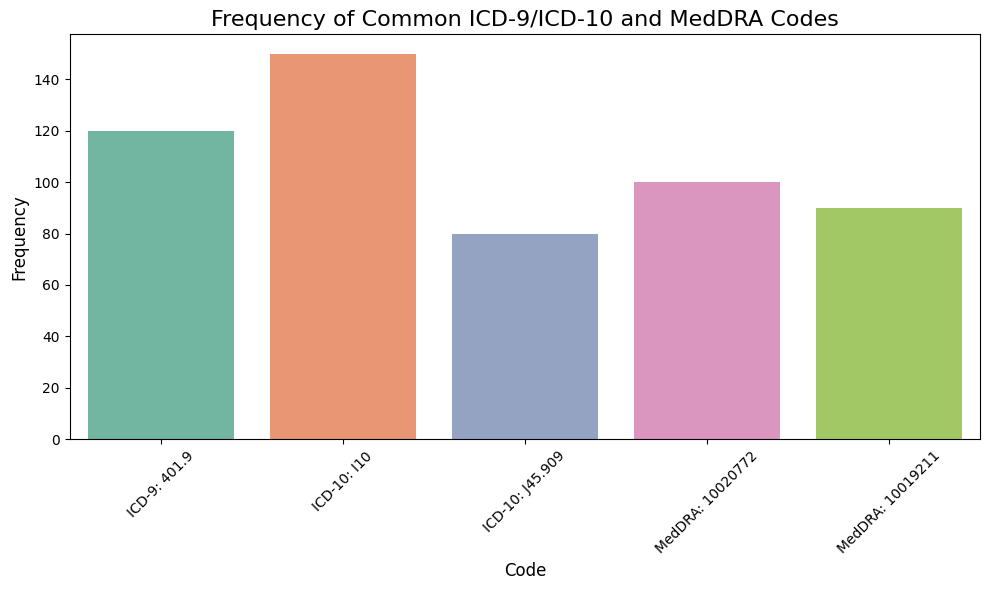

In [10]:

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
import pandas as pd

# Hypothetical data for bar chart
data = {
    'Code': ['ICD-9: 401.9', 'ICD-10: I10', 'ICD-10: J45.909', 'MedDRA: 10020772', 'MedDRA: 10019211'],
    'Frequency': [120, 150, 80, 100, 90]
}
df = pd.DataFrame(data)

# 1. Bar Chart: Frequency of Common ICD-9/ICD-10 and MedDRA Codes
plt.figure(figsize=(10, 6))
sns.barplot(x='Code', y='Frequency', data=df, palette='Set2')
plt.title('Frequency of Common ICD-9/ICD-10 and MedDRA Codes', fontsize=16)
plt.xlabel('Code', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



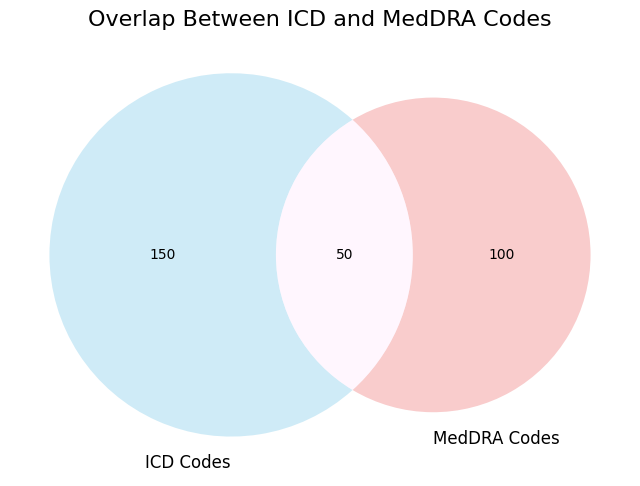

In [11]:
# 2. Venn Diagram: Overlap Between ICD and MedDRA Codes
# Hypothetical counts: 150 ICD-only, 100 MedDRA-only, 50 overlap
plt.figure(figsize=(8, 8))
venn2(subsets=(150, 100, 50), set_labels=('ICD Codes', 'MedDRA Codes'), set_colors=('skyblue', 'lightcoral'))
plt.title('Overlap Between ICD and MedDRA Codes', fontsize=16)
plt.show()

In [12]:
import pandas as pd

# Hypothetical dataset
data = {
    'Code': ['401.9', 'I10', 'J45.909', '10020772', '10019211', '428.0', 'E11.9', '10003553'],
    'Frequency': [120, 150, 80, 100, 90, 110, 130, 70],
    'Code_Type': ['ICD-9', 'ICD-10', 'ICD-10', 'MedDRA', 'MedDRA', 'ICD-9', 'ICD-10', 'MedDRA'],
    'Condition': ['Hypertension', 'Hypertension', 'Asthma', 'Asthma', 'Headache', 'Heart Failure', 'Diabetes', 'Diabetes']
}
df = pd.DataFrame(data)

Summary Statistics by Code Type:
           count        mean        std    min    25%    50%    75%    max
Code_Type                                                                 
ICD-10       3.0  120.000000  36.055513   80.0  105.0  130.0  140.0  150.0
ICD-9        2.0  115.000000   7.071068  110.0  112.5  115.0  117.5  120.0
MedDRA       3.0   86.666667  15.275252   70.0   80.0   90.0   95.0  100.0


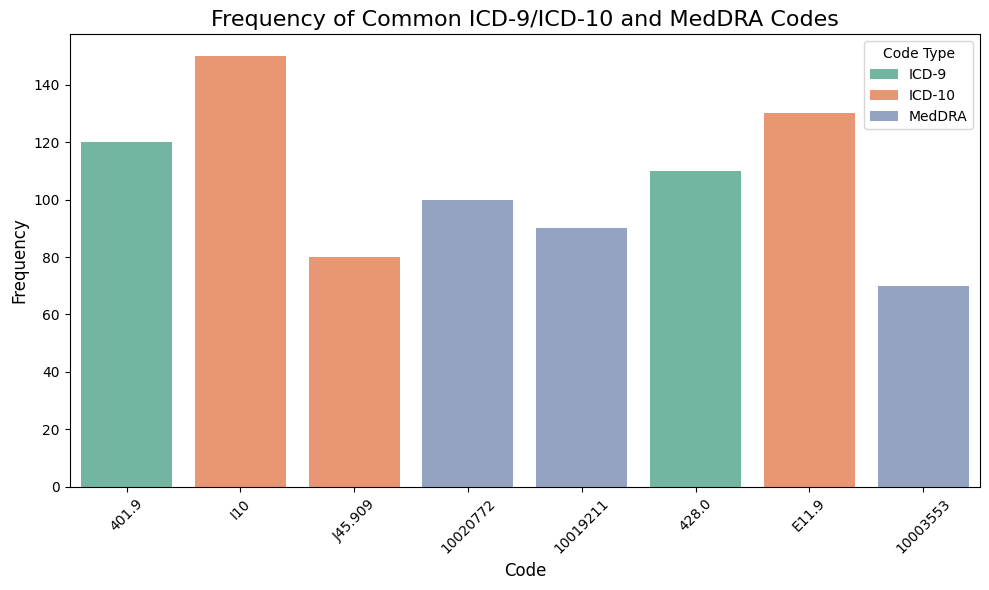

In [13]:
# 1. Summary Statistics
print("Summary Statistics by Code Type:")
summary_stats = df.groupby('Code_Type')['Frequency'].describe()
print(summary_stats)

# 2. Original Bar Chart: Frequency of Common Codes
plt.figure(figsize=(10, 6))
sns.barplot(x='Code', y='Frequency', data=df, hue='Code_Type', palette='Set2')
plt.title('Frequency of Common ICD-9/ICD-10 and MedDRA Codes', fontsize=16)
plt.xlabel('Code', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Code Type')
plt.tight_layout()
plt.show()

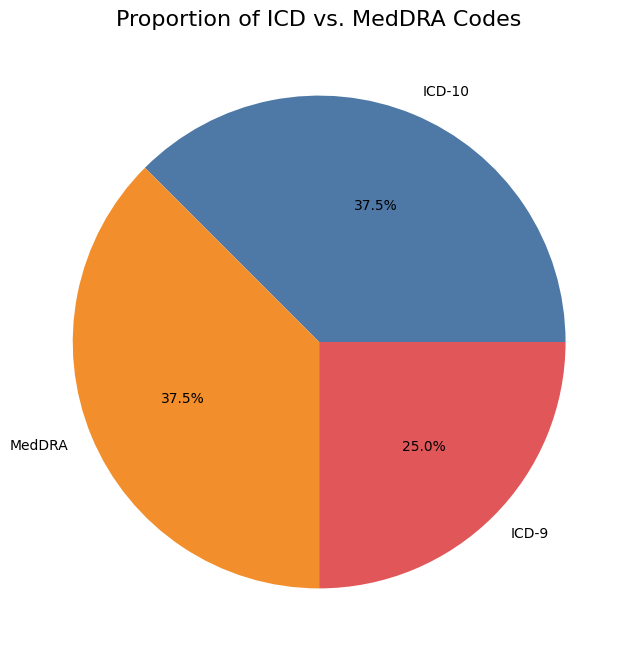

In [14]:
# 3. Pie Chart: Proportion of ICD vs. MedDRA Codes
code_type_counts = df['Code_Type'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(code_type_counts, labels=code_type_counts.index, autopct='%1.1f%%', colors=['#4e79a7', '#f28e2b', '#e15759'])
plt.title('Proportion of ICD vs. MedDRA Codes', fontsize=16)
plt.show()

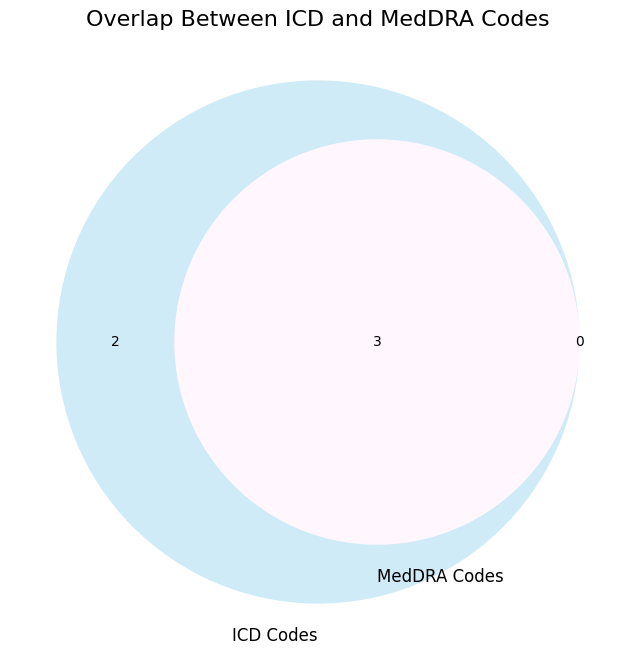

In [18]:
# 6. Venn Diagram: Overlap Between ICD and MedDRA Codes
# Hypothetical counts based on conditions (e.g., codes sharing same condition)
icd_count = df[df['Code_Type'].isin(['ICD-9', 'ICD-10'])]['Code'].nunique()  # 4 ICD codes
meddra_count = df[df['Code_Type'] == 'MedDRA']['Code'].nunique()  # 3 MedDRA codes
overlap = len(df[df['Condition'].duplicated()]['Condition'].unique())  # 2 conditions shared
plt.figure(figsize=(8, 8))
venn2(subsets=(icd_count - overlap, meddra_count - overlap, overlap),
      set_labels=('ICD Codes', 'MedDRA Codes'), set_colors=('skyblue', 'lightcoral'))
plt.title('Overlap Between ICD and MedDRA Codes', fontsize=16)
plt.show()

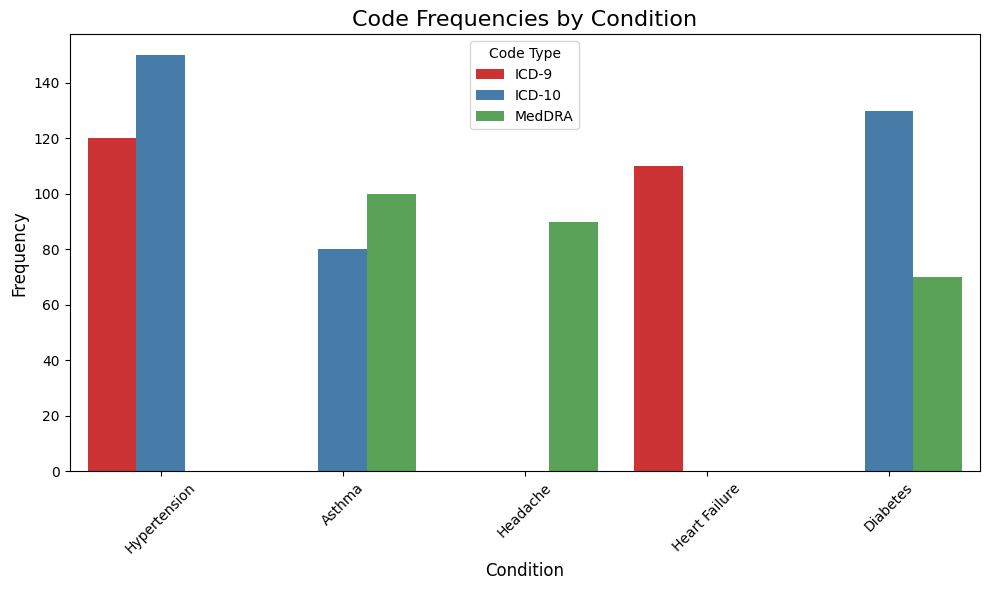

In [17]:
# 5. Grouped Bar Chart: Frequencies by Condition
plt.figure(figsize=(10, 6))
sns.barplot(x='Condition', y='Frequency', hue='Code_Type', data=df, palette='Set1')
plt.title('Code Frequencies by Condition', fontsize=16)
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Code Type')
plt.tight_layout()
plt.show()

In [19]:
# 7. Correlation Analysis (if additional numerical features exist)
# For demo, let's assume a hypothetical 'Severity_Score' column
df['Severity_Score'] = [3.5, 4.0, 2.8, 3.2, 3.0, 4.5, 3.8, 2.5]  # Hypothetical
correlation = df[['Frequency', 'Severity_Score']].corr()
print("\nCorrelation Matrix:")
print(correlation)


Correlation Matrix:
                Frequency  Severity_Score
Frequency        1.000000        0.782011
Severity_Score   0.782011        1.000000


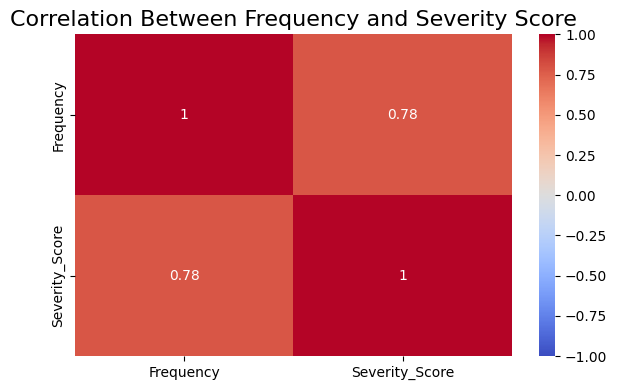

In [20]:
# Visualize correlation with a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Frequency and Severity Score', fontsize=16)
plt.tight_layout()
plt.show()